In [1]:
# Importação de livrarias
import os
import re
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Carga dos dados
Inicialmente é necessário fazer a separação entre os dados de treino e teste já que quando é realizado o download do dataset, esses diretórios estão dentro de "aclImdb".
Em seguida, já dentro do diretório, é necessário abrir os diretório de reviews positivos e classifica-los como 1 e os negativos como -1.

In [2]:
def load_data(data_dir):
    data = {}
    for split in ["train", "test"]:
        data[split] = []
        for sentiment in ["neg", "pos"]:
            if sentiment == 'pos':
                score = 1
            else: 
                score = -1
            path = os.path.join(data_dir, split, sentiment)
            file_names = os.listdir(path)
            for f_name in file_names:
                with open(os.path.join(path, f_name), "r", encoding="utf-8") as f:
                    review = f.read()
                    data[split].append([review, score])                         
    return data["train"], data["test"] 

train_data, test_data = load_data(data_dir="aclImdb/")

## Criação do DataFrame
Agora utilizo os dados retornados pela função para criar DataFrames do Pandas

In [3]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
train_data = pd.DataFrame(train_data, columns=['text', 'sentiment'])
test_data = pd.DataFrame(test_data,columns=['text', 'sentiment'])

In [4]:
def analisa_dados(data):
    print('Tamanho do dataset:\n', data.shape)
    print('\nVisualização dos 5 primeiros dados:\n', data.head())
    print('\nVisualização dos 5 últimos dados:\n', data.tail())
    print('\nExistem valores faltantes?', data.isnull().any().any())

In [5]:
analisa_dados(train_data)

Tamanho do dataset:
 (25000, 2)

Visualização dos 5 primeiros dados:
                                                 text  sentiment
0  Story of a man who has unnatural feelings for ...         -1
1  Airport '77 starts as a brand new luxury 747 p...         -1
2  This film lacked something I couldn't put my f...         -1
3  Sorry everyone,,, I know this is supposed to b...         -1
4  When I was little my parents took me along to ...         -1

Visualização dos 5 últimos dados:
                                                     text  sentiment
24995  Seeing as the vote average was pretty low, and...          1
24996  The plot had some wretched, unbelievable twist...          1
24997  I am amazed at how this movie(and most others ...          1
24998  A Christmas Together actually came before my t...          1
24999  Working-class romantic drama from director Mar...          1

Existem valores faltantes? False


Os dados parecem estar ordernados por classificação de reviews, primeiros os negativos e depois os positivos.
Será necessário realizar um "embaralhamento"

In [6]:
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html
from sklearn.utils import shuffle
train_data = shuffle(train_data)
train_data.reset_index(inplace=True, drop=True)

test_data = shuffle(test_data)
test_data.reset_index(inplace=True, drop=True)

In [7]:
analisa_dados(train_data)

Tamanho do dataset:
 (25000, 2)

Visualização dos 5 primeiros dados:
                                                 text  sentiment
0  Time paradoxes are the devil's snare for under...          1
1  I second the motion to make this into a movie,...          1
2  If Alien, Jurassic Park and countless other sc...         -1
3  The first two sequences of this movie set up t...          1
4  I rented this movie because I was browsing thr...         -1

Visualização dos 5 últimos dados:
                                                     text  sentiment
24995  Red Rock West is one of those rare films that ...          1
24996  I debated as to whether or not I should tick t...         -1
24997  A still famous but decadent actor (Morgan Free...         -1
24998  I got hooked on this as apparently ABC has lic...          1
24999  WWE was in need of a saviour as Wrestlemania 1...          1

Existem valores faltantes? False


In [8]:
analisa_dados(test_data)

Tamanho do dataset:
 (25000, 2)

Visualização dos 5 primeiros dados:
                                                 text  sentiment
0  I gotta go with my boy Allen (who also reviewe...         -1
1  I saw this film over Christmas, and what a gre...          1
2  If there are people that don't like this movie...          1
3  So, as far as I gather, this episode is trying...         -1
4  Last night, I saw A PECK ON THE CHEEK (KANNATH...          1

Visualização dos 5 últimos dados:
                                                     text  sentiment
24995  Mike Nichols in finest form. I was not a fan o...          1
24996  This might very well be the worst movie I've s...         -1
24997  The first reviewer is right - In this movie we...          1
24998  The Standard bearer of all movie serials, the ...          1
24999  In this film, the astronauts sent to explore a...          1

Existem valores faltantes? False


In [9]:
train_data['sentiment'].value_counts()

 1    12500
-1    12500
Name: sentiment, dtype: int64

In [10]:
test_data['sentiment'].value_counts()

 1    12500
-1    12500
Name: sentiment, dtype: int64

## Pre Processamento

In [12]:
def limpa_texto(text):  
    # remove tags do HTML
    text = re.sub(r'<.*?>', '', text)    
    # remove os caracteres (\), (') e (")
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    # converte o texto para lowercase
    text = text.strip().lower()    
    # remove os caracteres de pontuação
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'            
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)   
    # remove digitos dentro de uma palavra, exemplo brasil123 = brasil
    text = re.sub('W*dw*','',text)
    # remove espaços extras
    text = re.sub(' +', ' ', text)
                 
    return text

### Deletar os números

In [11]:
# Deletar os números
train_data['text'] = train_data['text'].str.replace('\d+', '')
test_data['text'] = test_data['text'].str.replace('\d+', '')

## Modelagem
Usar o CountVectorize para gerar a matriz de frequência

Aplicarei o parâmetro stop_words para excluir as palavras que não agregam valor ao modelo

Também aplicarei o parâmetro preprocessor para chamar a nossa função que limpa o texto

In [13]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
start = time()
vectorizer = CountVectorizer(stop_words="english", preprocessor=limpa_texto)
training_features = vectorizer.fit_transform(train_data["text"]) 
#print('Training Features' + str(training_features))
test_features = vectorizer.transform(test_data["text"])
#print('Testing Features' + str(test_features))
print ('Tempo: {:.2f}s'.format(time()-start))

Tempo: 42.36s


### LinearSVC
Com números = 83.49

Sem Números = 83.48

In [14]:
# Training
start = time()

model1 = LinearSVC(verbose = 1)
model1.fit(training_features, train_data["sentiment"])
y_pred = model1.predict(test_features)
print(y_pred)
# Evaluation
acc = accuracy_score(test_data["sentiment"], y_pred)
print ('Tempo: {:.2f}s\n'.format(time()-start))
print("Accuracy on the IMDB dataset: {:.2f}".format(acc*100))
print(classification_report(test_data['sentiment'], model1.predict(test_features), target_names=['Negative -1','Positive 1']))

[LibLinear][-1  1  1 ...  1 -1  1]
Tempo: 8.31s

Accuracy on the IMDB dataset: 83.48
              precision    recall  f1-score   support

 Negative -1       0.83      0.85      0.84     12500
  Positive 1       0.84      0.82      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.84      0.83      0.83     25000
weighted avg       0.84      0.83      0.83     25000



### LogisticRegression
Com Números = 86.00

Sem Números = 86.04

In [15]:
# Training
from sklearn.linear_model import LogisticRegression
start = time()

model2 = LogisticRegression(verbose = 1)
model2.fit(training_features, train_data["sentiment"])
y_pred = model2.predict(test_features)
print(y_pred)
# Evaluation
acc = accuracy_score(test_data["sentiment"], y_pred)
print ('Tempo: {:.2f}s\n'.format(time()-start))
print("Accuracy on the IMDB dataset: {:.2f}".format(acc*100))
print(classification_report(test_data['sentiment'], model2.predict(test_features), target_names=['Negative -1','Positive 1']))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[-1  1  1 ...  1 -1  1]
Tempo: 5.75s

Accuracy on the IMDB dataset: 86.04
              precision    recall  f1-score   support

 Negative -1       0.85      0.87      0.86     12500
  Positive 1       0.87      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s finished


### RidgeClassifier
Com Números = 75.69

Sem Números = 75.79

In [16]:
# Training
from sklearn.linear_model import RidgeClassifier
start = time()

model3 = RidgeClassifier()
model3.fit(training_features, train_data["sentiment"])
y_pred = model3.predict(test_features)
print(y_pred)
# Evaluation
acc = accuracy_score(test_data["sentiment"], y_pred)
print ('Tempo: {:.2f}s\n'.format(time()-start))
print("Accuracy on the IMDB dataset: {:.2f}".format(acc*100))
print(classification_report(test_data['sentiment'], model3.predict(test_features), target_names=['Negative -1','Positive 1']))

[-1  1 -1 ... -1 -1  1]
Tempo: 18.06s

Accuracy on the IMDB dataset: 75.79
              precision    recall  f1-score   support

 Negative -1       0.75      0.77      0.76     12500
  Positive 1       0.77      0.74      0.75     12500

    accuracy                           0.76     25000
   macro avg       0.76      0.76      0.76     25000
weighted avg       0.76      0.76      0.76     25000



## PassiveAggressiveClassifier
Com Números = 84.02

Sem Números = 83.81

In [17]:
from sklearn.linear_model import PassiveAggressiveClassifier
start = time()

model4= PassiveAggressiveClassifier(max_iter=150, random_state=0)
model4.fit(training_features, train_data["sentiment"])
y_pred = model4.predict(test_features)
print(y_pred)
# Evaluation
acc = accuracy_score(test_data["sentiment"], y_pred)
print ('Tempo: {:.2f}s\n'.format(time()-start))
print("Accuracy on the IMDB dataset: {:.2f}".format(acc*100))
print(classification_report(test_data['sentiment'], model3.predict(test_features), target_names=['Negative -1','Positive 1']))

[-1  1  1 ...  1 -1  1]
Tempo: 0.97s

Accuracy on the IMDB dataset: 83.81
              precision    recall  f1-score   support

 Negative -1       0.75      0.77      0.76     12500
  Positive 1       0.77      0.74      0.75     12500

    accuracy                           0.76     25000
   macro avg       0.76      0.76      0.76     25000
weighted avg       0.76      0.76      0.76     25000



## TfidfVectorizer

In [18]:
vectorizer = TfidfVectorizer(stop_words="english",
                             preprocessor=limpa_texto,
                             ngram_range=(1, 2))
training_features = vectorizer.fit_transform(train_data["text"]) 
test_features = vectorizer.transform(test_data["text"])

### LogisticRegression
Com números = 87.57

Sem Números = 87.52

In [19]:
start = time()

model = LogisticRegression(verbose = 1)
model.fit(training_features, train_data["sentiment"])
y_pred = model.predict(test_features)
print(y_pred)
# Evaluation
acc = accuracy_score(test_data["sentiment"], y_pred)
print ('Tempo: {:.2f}s\n'.format(time()-start))
print("Accuracy on the IMDB dataset: {:.2f}".format(acc*100))
print(classification_report(test_data['sentiment'], model.predict(test_features), target_names=['Negative -1','Positive 1']))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[-1  1  1 ...  1 -1  1]
Tempo: 29.44s

Accuracy on the IMDB dataset: 87.52
              precision    recall  f1-score   support

 Negative -1       0.88      0.87      0.87     12500
  Positive 1       0.87      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.3s finished


### Matrix de Confusão

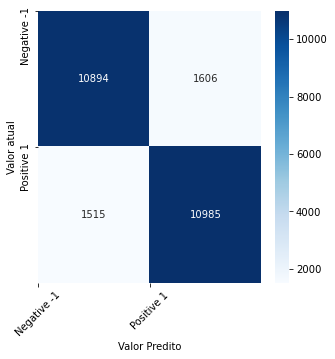

In [20]:
cm = confusion_matrix(test_data['sentiment'], model.predict(test_features))
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, cmap = plt.cm.Blues, fmt = '.8g')
classes = ['Negative -1', 'Positive 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Valor Predito')
plt.ylabel('Valor atual')
plt.show()

Avaliação dos modelos e técnicas:

    Não farei uso do processo de deletar números pois o mesmo não trouxe resultados significativos.